In [1]:
#!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torch torchvision



  Using cached torch-2.2.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.17.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached 

In [2]:
## The usual imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## for printing image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(torch.__version__)

2.2.1+cu121


In [4]:
## parameter denoting the batch size
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

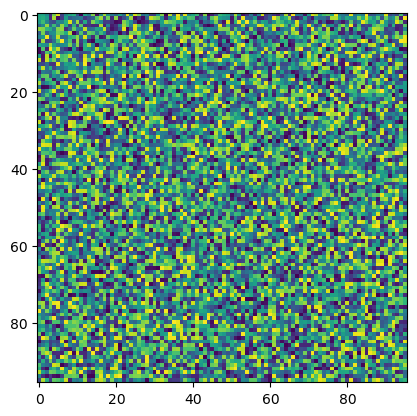

In [5]:
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))
plt.imshow(image)

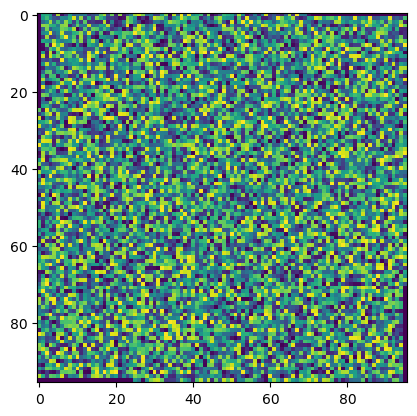

In [6]:
## dummy transformation
dummy_transform = transforms.Compose(
    [transforms.RandomRotation(45)])

dummy_result = dummy_transform(image)

plt.imshow(dummy_result)

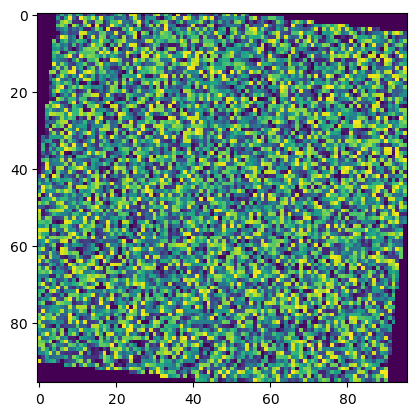

In [7]:

## dummy transform 
dummy2_transform = transforms.Compose(
    [transforms.RandomRotation(45), transforms.RandomVerticalFlip()])

dummy2_result = dummy2_transform(image)

plt.imshow(dummy2_result)

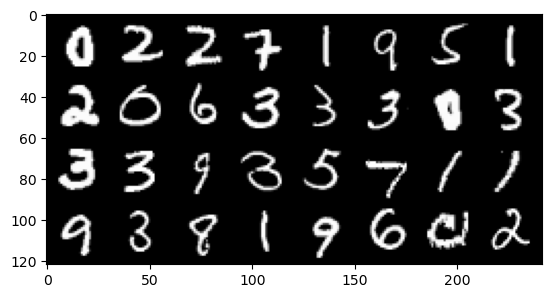

In [8]:
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [9]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [10]:
## the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.d2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        x = self.dropout(x)
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [11]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [12]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:

## utility function to compute accuracy
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## commence training
    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))